# Random Forest Challenge

We will be comparing the accuracy and speed of a single decision tree vs. a random forest. The challenge here is to make the most accurate decision tree possible and compare it to the simplest random forest possible.

For this exercise we will be using the popular [Wisconsin Breast Cancer dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Original%29).  Our goal will be to predict malignant tumors.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import time

In [2]:
cancer = pd.read_csv('breast-cancer-wisconsin.data.txt', na_values='?')
cancer.columns = ['sample', 
                  'clump_thickness', 
                  'cell_size_uni', 
                  'cell_shape_uni', 
                  'marginal_adhesion',
                  'single_epi_cell_size',
                  'bare_nuclei',
                  'bland_chromatin',
                  'normal_nucleoli',
                  'mitoses',
                  'class']
cancer.dropna(inplace=True)

In [3]:
cancer.head()

,sample,clump_thickness,cell_size_uni,cell_shape_uni,marginal_adhesion,single_epi_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1002945,5,4,4,5,7,10.0,3,2,1,2
1,1015425,3,1,1,1,2,2.0,3,1,1,2
2,1016277,6,8,8,1,3,4.0,3,7,1,2
3,1017023,4,1,1,3,2,1.0,3,1,1,2
4,1017122,8,10,10,8,7,10.0,9,7,1,4


In [4]:
cancer.describe()

,sample,clump_thickness,cell_size_uni,cell_shape_uni,marginal_adhesion,single_epi_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
count,6.820000e+02,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000
mean,1.076833e+06,4.441349,3.153959,3.218475,2.832845,3.236070,3.548387,3.445748,2.872434,1.604106,2.700880
std,6.210926e+05,2.822751,3.066285,2.989568,2.865805,2.224214,3.645226,2.451435,3.054065,1.733792,0.954916
min,6.337500e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.774540e+05,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171820e+06,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238741e+06,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [5]:
cancer['class'].value_counts()

2    443
4    239
Name: class, dtype: int64

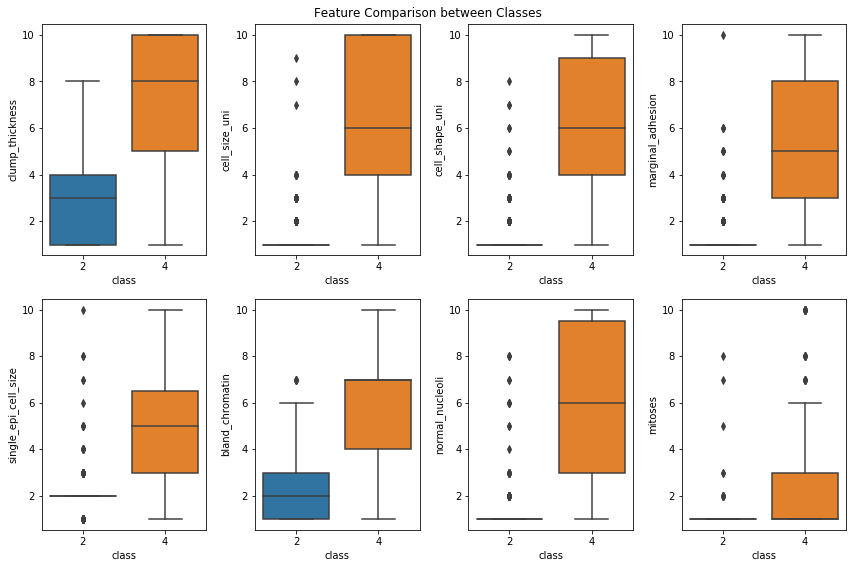

In [6]:
plt.figure(figsize=(12,8))
plt.suptitle('Feature Comparison between Classes')

plt.subplot(241)
sns.boxplot(data=cancer, y='clump_thickness', x='class')

plt.subplot(242)
sns.boxplot(data=cancer, y='cell_size_uni', x='class')

plt.subplot(243)
sns.boxplot(data=cancer, y='cell_shape_uni', x='class')

plt.subplot(244)
sns.boxplot(data=cancer, y='marginal_adhesion', x='class')

plt.subplot(245)
sns.boxplot(data=cancer, y='single_epi_cell_size', x='class')

plt.subplot(246)
sns.boxplot(data=cancer, y='bland_chromatin', x='class')

plt.subplot(247)
sns.boxplot(data=cancer, y='normal_nucleoli', x='class')

plt.subplot(248)
sns.boxplot(data=cancer, y='mitoses', x='class')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

### Data description

We have 698 samples here and no missing data. The target variable is `class` where 2 == benign tumor and 4 == malignant tumor.  There is a class imbalance present, with malignant tumors only representing 34% of the total dataset.


### Decision Tree Model

The most accurate decision tree is likely to include all of the data.  So we will test that first.

In [7]:
X_variables = cancer.iloc[:, 1:10]

# One hot encoding the variables
def onehot(df, cols):
    for c in cols:
        dummies = pd.get_dummies(df[c], prefix=c, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

X_col = X_variables.columns
X_dt = onehot(X_variables, X_col)
X_dt = X_dt.iloc[:,9:]
Y = cancer['class'].replace(to_replace={4:1, 2:0})


In [8]:
print(X_dt.shape)
X_dt.head()

(682, 89)


,clump_thickness_1,clump_thickness_2,clump_thickness_3,clump_thickness_4,clump_thickness_5,clump_thickness_6,clump_thickness_7,clump_thickness_8,clump_thickness_9,clump_thickness_10,...,normal_nucleoli_10,mitoses_1,mitoses_2,mitoses_3,mitoses_4,mitoses_5,mitoses_6,mitoses_7,mitoses_8,mitoses_10
0,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [9]:
dt = tree.DecisionTreeClassifier(
    criterion='gini',
    max_features=89
)

cross_val_score(dt, X_dt, Y, cv=10)

array([0.91304348, 0.89855072, 0.89855072, 0.92647059, 0.94117647,
       0.88235294, 0.95588235, 0.94117647, 0.91176471, 0.95522388])

While the cross validation scores are high, the variance between scores is obviously sub-optimal.  I'm not quite sure why this would be occurring.


### Random Forest Model

To make the simplest random forest model possible, we will first run a random forest with all of the features and output the feature importance of each. Afterwards, we'll use only the one or two most important features in the *real* model.  From the box plots above, it looks the top features should be either `clump_thickness`, `cell_size_uni`, or `cell_shape_uni`.

In [10]:
rfc_test = RandomForestClassifier(n_estimators=100)
rfc_test.fit(X_dt, Y)

# cross_val_score(rfc_test, X_dt, Y, cv=10)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [11]:
# Accessing, storing, and printing 10 most important features
feat_names = X_dt.columns
feat_importance = rfc_test.feature_importances_
indicies = np.argsort(feat_importance)

c = 1
for i in indicies[-10:]:
    print(f'{11-c}.  ', feat_names[i], feat_importance[i])
    c += 1


10.   bland_chromatin_1 0.02061511948257322
9.   clump_thickness_10 0.020796203644233572
8.   mitoses_1 0.03035715474491179
7.   bare_nuclei_10.0 0.05698005871248431
6.   single_epi_cell_size_2 0.06529615679016625
5.   normal_nucleoli_1 0.06599799205784192
4.   cell_shape_uni_1 0.08814973941958254
3.   marginal_adhesion_1 0.09509595520519042
2.   cell_size_uni_1 0.13047975522807292
1.   bare_nuclei_1.0 0.1318710397162905


Now that we have the 10 most important features, we'll work from 1 feature to **n** features until we have a decent model.

In [12]:
# Instantiating the model with just the top feature
X_rfc1 = np.array(X_dt.loc[:, 'cell_shape_uni_1']).reshape(-1,1)

rfc1 = RandomForestClassifier(n_estimators=10) # 10 estimators to keep compute time small
rfc1.fit(X_rfc1, Y)

cross_val_score(rfc1, X_rfc1, Y, cv=10)

array([0.85507246, 0.89855072, 0.88405797, 0.88235294, 0.75      ,
       0.76470588, 0.91176471, 0.83823529, 0.83823529, 0.88059701])

Some good scores in there but also with some pretty mediocre scores too.  Let's add another feature.

In [13]:
# Adding the second best feature
X_rfc2 = np.array(X_dt.loc[:, ['bare_nuclei_1.0', 'cell_shape_uni_1']]).reshape(-1,2)

rfc2 = RandomForestClassifier(n_estimators=10)
rfc2.fit(X_rfc2, Y)

cross_val_score(rfc2, X_rfc2, Y, cv=10)

array([0.89855072, 0.94202899, 0.94202899, 0.92647059, 0.95588235,
       0.89705882, 0.95588235, 0.97058824, 0.94117647, 0.95522388])

The model definitely improved.  Let's see if adding one more feature will bump up all the cross validation scores above 0.9.

In [14]:
# Adding the third best feature
X_rfc3 = np.array(X_dt.loc[:, ['bare_nuclei_1.0', 'cell_size_uni_1', 'cell_shape_uni_1']]).reshape(-1,3)

rfc3 = RandomForestClassifier(n_estimators=10)
rfc3.fit(X_rfc3, Y)

cross_val_score(rfc3, X_rfc3, Y, cv=10)

array([0.91304348, 0.94202899, 0.95652174, 0.92647059, 0.95588235,
       0.86764706, 0.97058824, 0.97058824, 0.95588235, 0.95522388])

Not quite there, add one more!

In [15]:
# Adding the fifth best feature, skipping the fourth best feature
# because it is from the same base feature as 'bare_nuclei_1.0' and didn't add any information

X_rfc4 = X_dt.loc[:, ['bare_nuclei_1.0', 'cell_size_uni_1', 'cell_shape_uni_1', 'single_epi_cell_size_2']]
X_rfc4 = np.array(X_rfc4).reshape(-1,4)

rfc4 = RandomForestClassifier(n_estimators=10)
rfc4.fit(X_rfc4, Y)

cross_val_score(rfc4, X_rfc4, Y, cv=10)

array([0.91304348, 0.97101449, 0.94202899, 0.92647059, 0.89705882,
       0.88235294, 0.97058824, 0.97058824, 0.94117647, 0.97014925])

While we didn't get all the CV scores above 0.90, I'm going to call this good enough.



### Final Models - Runtime Test

Now that we have tuned the models to a sufficient degree, let's see how their runtimes compare as a measure of accuracy versus compute power.

In [16]:
# Setting up test/train splits for each model

x_dt_train, x_dt_test, y_dt_train, y_dt_test = train_test_split(X_dt, Y)
x_rf_train, x_rf_test, y_rf_train, y_rf_test = train_test_split(X_rfc4, Y)

In [17]:
# Decision Tree Model

dt_start_time = time.time()

dt = tree.DecisionTreeClassifier(
    criterion='gini',
    max_features=89
)

dt.fit(x_dt_train, y_dt_train)
y_dt_ = dt.predict(x_dt_test)

dt_test_result = y_dt_ + np.array(y_dt_test)
dt_misclass = np.unique(dt_test_result, return_counts=True)[1][1]

print('{} out of {} correct'.format((len(y_dt_) - dt_misclass), len(y_dt_)))
print('Time: ', (time.time() - dt_start_time))

158 out of 171 correct
Time:  0.0032482147216796875


In [18]:
# Random Forest Model

rf_start_time = time.time()

rfc4 = RandomForestClassifier(n_estimators=10)
rfc4.fit(x_rf_train, y_rf_train)

y_rf_ = rfc4.predict(x_rf_test)

rf_test_result = y_rf_ + np.array(y_rf_test)
rf_misclass = np.unique(rf_test_result, return_counts=True)[1][1]

print('{} out of {} correct'.format((len(y_rf_) - rf_misclass), len(y_rf_)))
print('Time: ', (time.time() - rf_start_time))

163 out of 171 correct
Time:  0.010724067687988281


In [19]:
print('Time ratio: ', 0.010542869567871094/0.0042378902435302734)
print('Decision Tree Accuracy :', 155/171)
print('Random Forest Accuracy :', 162/171)

Time ratio:  2.487763713080169
Decision Tree Accuracy : 0.9064327485380117
Random Forest Accuracy : 0.9473684210526315


# Test Results

The Random Forest was obviously a more accurate model, however it took 2.5 times as long to run as the Decision Tree.  While that performance difference does not matter with such a small data set, it would obviously matter given a large data set.